# Montando Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importando Pacotes

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.manifold import TSNE
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import plotly.express as px

## Dataset

In [3]:
# Carregando dataset
df = pd.read_csv('/content/drive/MyDrive/tarefa clustering Joao/segmentation_data.csv')

## Exploratory Analysis

In [4]:
df.shape

(200, 5)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [6]:
df.duplicated().sum()

0

## Drop Customer ID

In [7]:
df.drop(["CustomerID"], axis = 1, inplace=True)

In [8]:
import plotly.express as px
fig = px.scatter(df, x='Age', y='Annual Income (k$)')

# Exibir o gráfico
fig.show()


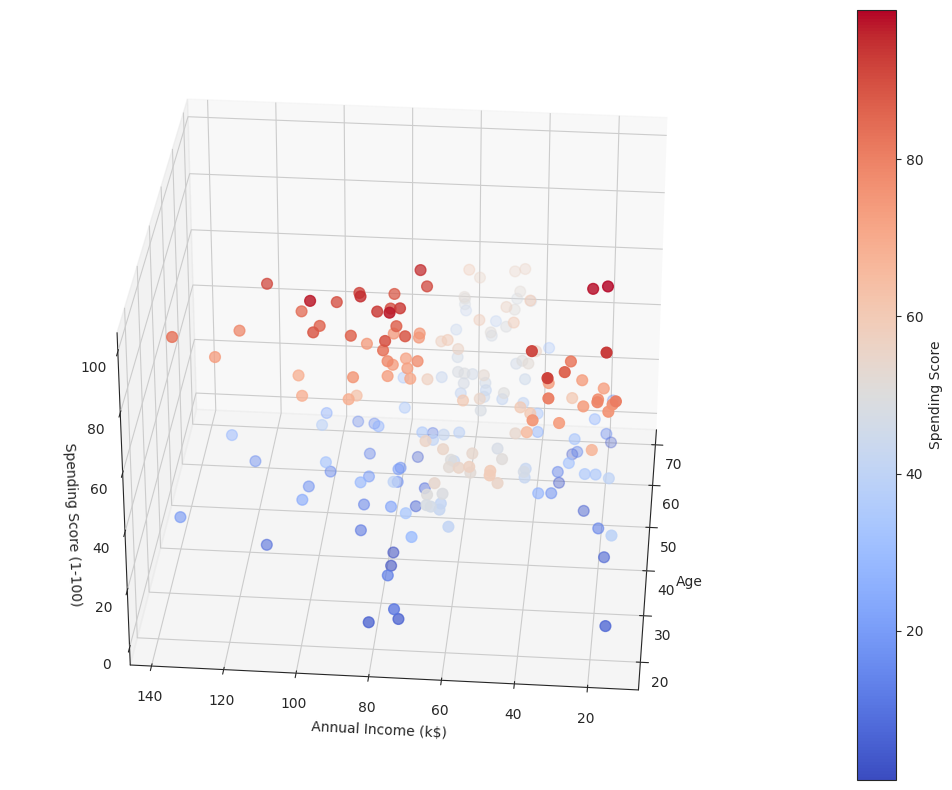

In [9]:
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("white")
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df.Age, df["Annual Income (k$)"], df["Spending Score (1-100)"],
    c=df["Spending Score (1-100)"], cmap='coolwarm', marker='o', s=60
)

ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
cbar = plt.colorbar(scatter)
cbar.set_label('Spending Score')

plt.show()

In [10]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow

    # Calcular o número de linhas (nGraphRow) arredondando para cima
    nGraphRow = math.ceil(nGraphRow)

    # Definir uma paleta de cores personalizada com duas cores
    custom_palette = sns.color_palette(["#FF5733", "#33FF57"])

    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar(color=custom_palette)  # Aplicar a paleta de cores personalizada
        else:
            columnDf.hist(color=custom_palette[0])  # Usar a primeira cor da paleta para histogramas
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()



In [11]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title('Correlation Matrix', fontsize=15)
    plt.show()


In [12]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


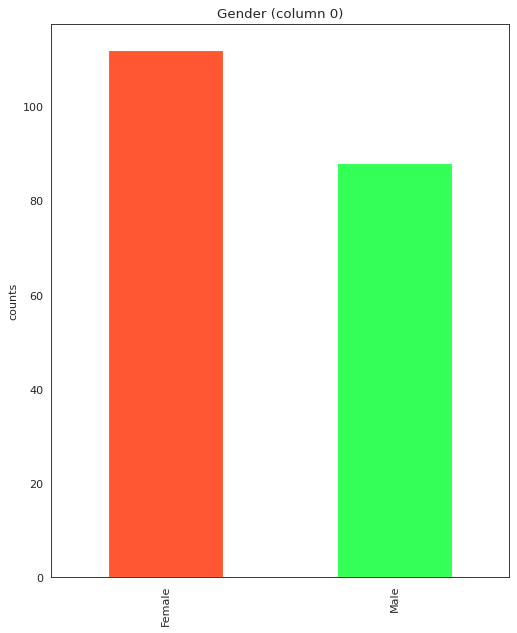

In [13]:
plotPerColumnDistribution(df, 10, 5)

<ipython-input-11-4b32ad3c3c74>:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.

<ipython-input-11-4b32ad3c3c74>:8: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



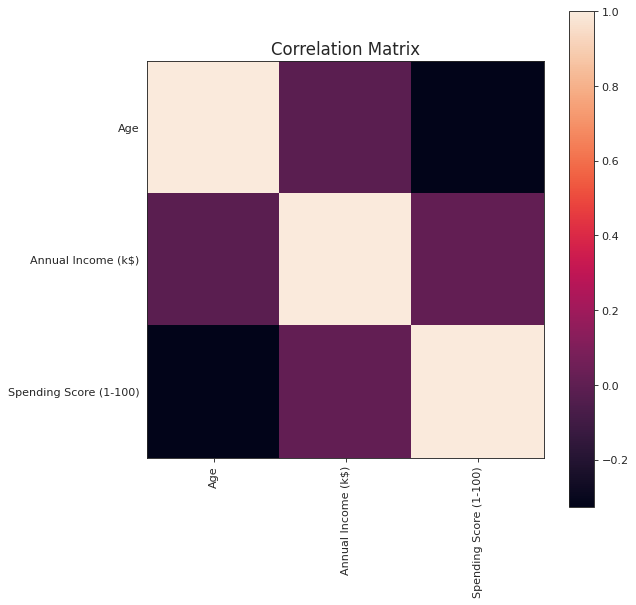

In [14]:
plotCorrelationMatrix(df, 8)

<ipython-input-12-45d7bdcfca59>:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.



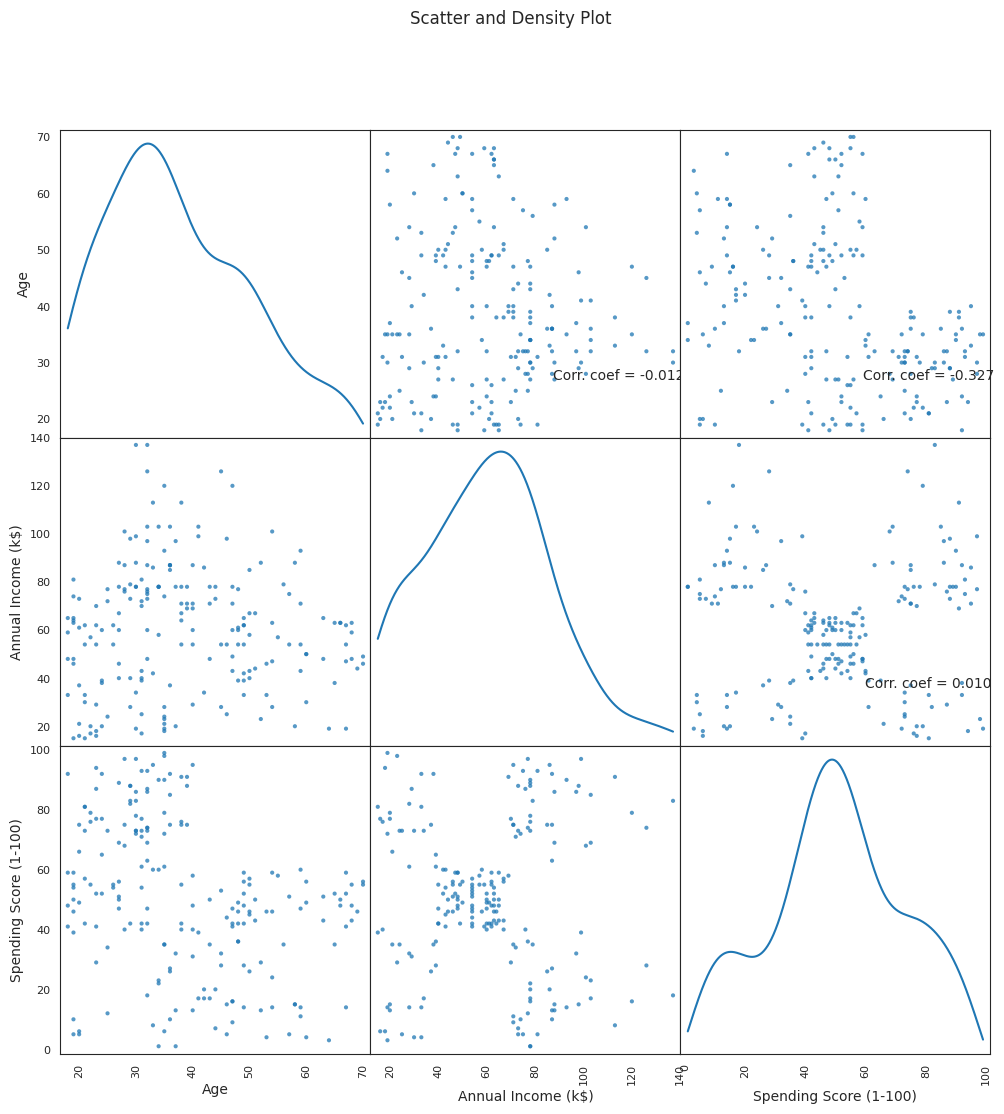

In [15]:
plotScatterMatrix(df, 12, 10)

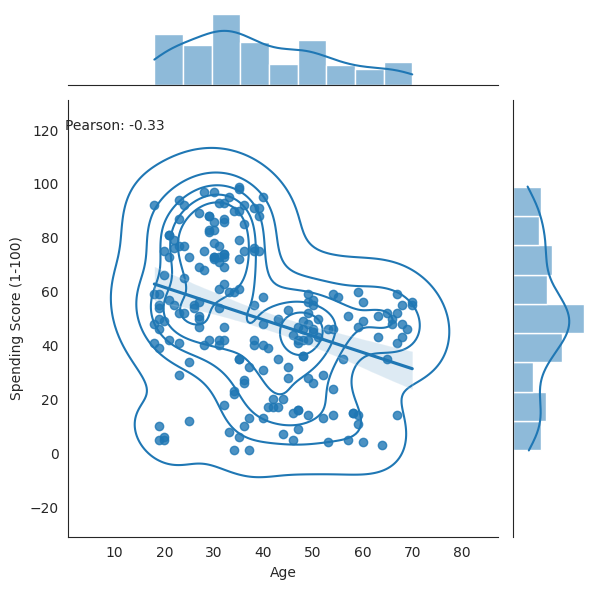

In [16]:
# Calculando a correlação de Pearson
corr, _ = pearsonr(df['Age'], df['Spending Score (1-100)'])

# Plotando um jointplot com uma regressão linear e densidade
joint_plot = sns.jointplot(x='Age', y='Spending Score (1-100)', data=df, kind='reg')
joint_plot.plot_joint(sns.kdeplot, zorder=0, n_levels=6)

# Adicionando o valor da correlação de Pearson ao gráfico
plt.text(0, 120, 'Pearson: {:.2f}'.format(corr))

# Exibindo o gráfico
plt.show()



# Método do cotovelo

O Método Elbow é uma técnica que usamos para determinar o número de centróides (k) a serem usados ​​em um algoritmo de agrupamento k-means. Neste método, para determinar o valor k, iteramos continuamente de k = 1 a k = n (aqui n é o hiperparâmetro que escolhemos de acordo com nossos requisitos).

In [18]:
X_numerics = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

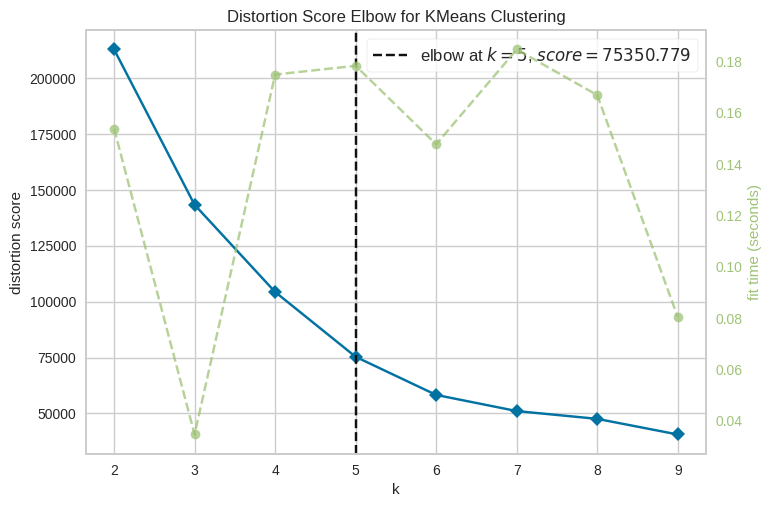

In [19]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1, n_init = 6)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

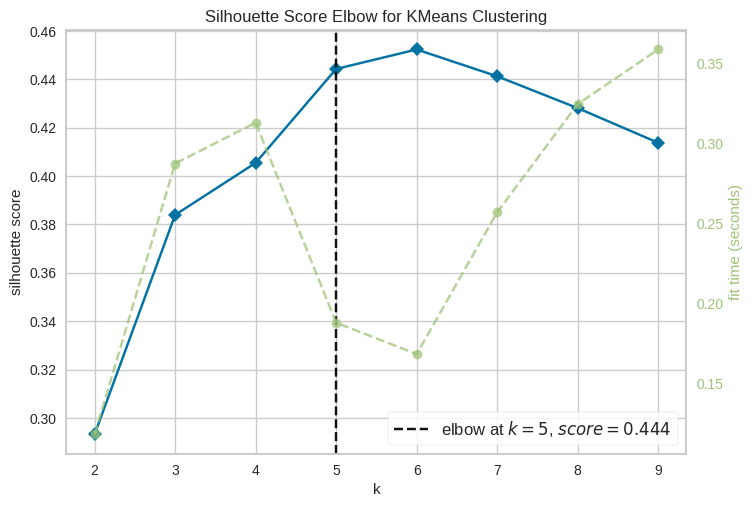

In [22]:
model = KMeans(random_state=1, n_init= 6)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

### Se K = 4 ou 5 , um deles será o besk K , tentaremos os dois

# KMeans

In [ ]:
km = KMeans(n_clusters=5, n_init= 6)
clusters = km.fit_predict(df.iloc[:,1:])# excluding Genre column

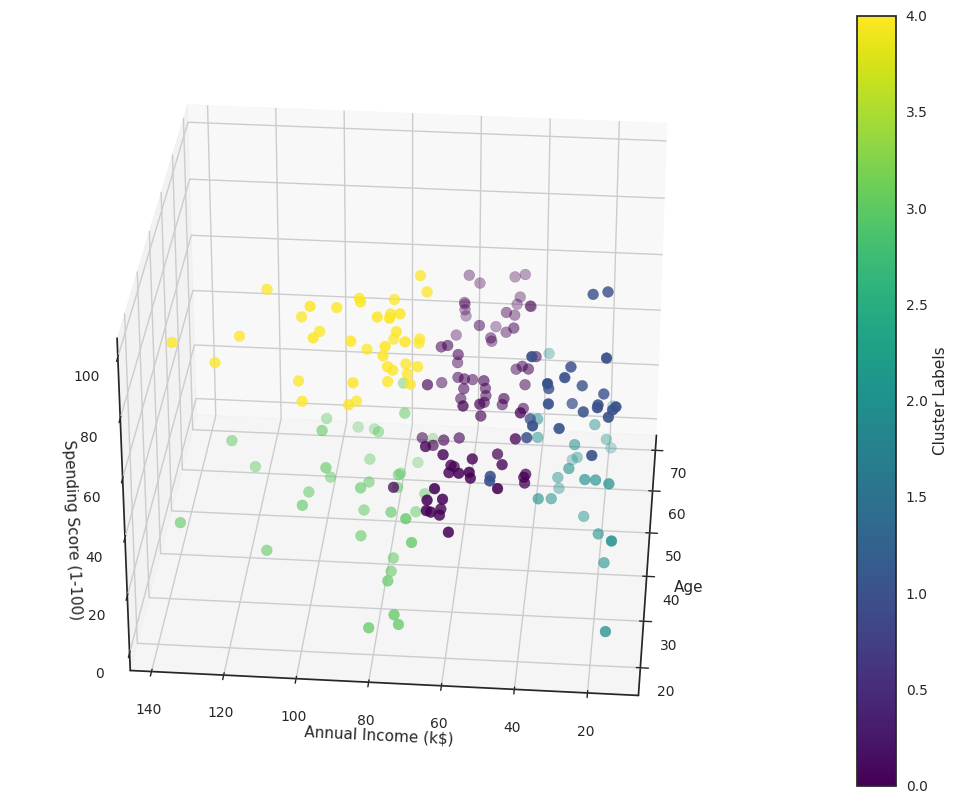

In [ ]:
sns.set_style("white")
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'],
    c=clusters, cmap='viridis', s=60
)

ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Labels')

plt.show()

### Tentando K = 6

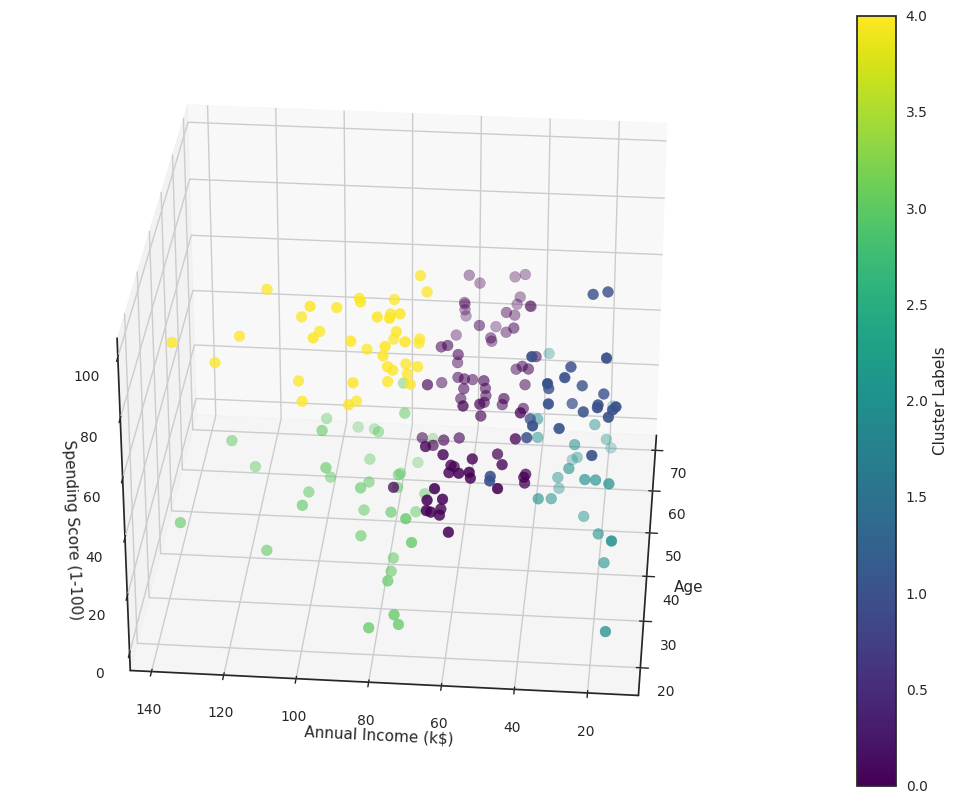

In [ ]:
km = KMeans(n_clusters=6, n_init= 6)
clusters2 = km.fit_predict(df.iloc[:,1:])

sns.set_style("white")
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'],
    c=clusters, cmap='viridis', s=60
)

ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Labels')

plt.show()

### Mudando as Cores

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



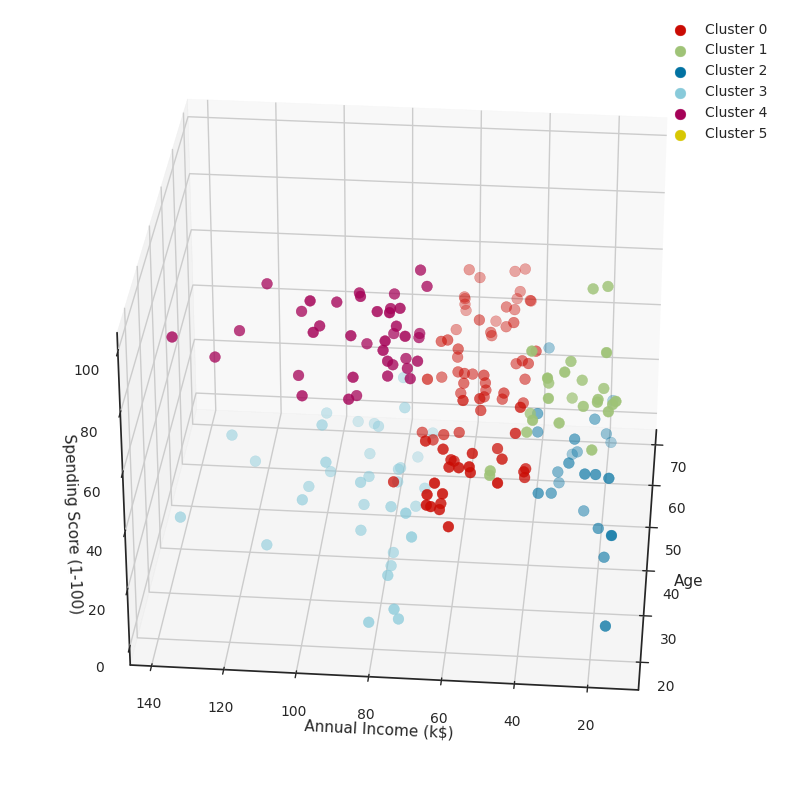

In [ ]:
km = KMeans(n_clusters=6)
clusters3 = km.fit_predict(df.iloc[:,1:])
cluster_colors = ['r', 'g', 'b', 'c', 'm', 'y']

sns.set_style("white")
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'],
    c=[cluster_colors[i] for i in clusters], s=60
)

ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')

for i, color in enumerate(cluster_colors):
    ax.scatter([], [], [], c=color, label=f'Cluster {i}', s=60)

ax.legend()

plt.show()

### comparando o desempenho de k=5 e k=6:

####  Silhouette Score:


Calcule a pontuação da silhueta para k=5 e k=6. A pontuação da silhueta mede a semelhança de cada ponto de dados com seu próprio cluster em comparação com outros clusters. Pontuações de silhueta mais altas indicam melhor agrupamento. Você pode escolher o k com a pontuação de silhueta mais alta.

In [ ]:
from sklearn.metrics import silhouette_score
kmeans_5 = KMeans(n_clusters=5, n_init=6)
clusters_5 = kmeans_5.fit_predict(df.iloc[:, 1:])
silhouette_avg_5 = silhouette_score(df.iloc[:, 1:], clusters_5)
print(f"Silhouette Score for k=5: {silhouette_avg_5}")

# Calculate Silhouette Score for k=5
kmeans_6 = KMeans(n_clusters=56, n_init=6)
clusters_6 = kmeans_6.fit_predict(df.iloc[:, 1:])
silhouette_avg_6 = silhouette_score(df.iloc[:, 1:], clusters_6)
print(f"Silhouette Score for k=6: {silhouette_avg_6}")

Silhouette Score for k=5: 0.4405402713418793
Silhouette Score for k=6: 0.3368557517249424


k = 5 é o melhor

In [ ]:
import plotly.graph_objects as go
from sklearn.cluster import KMeans
import pandas as pd

# Aplicar o algoritmo K-Means para clusterização
km = KMeans(n_clusters=5)
clusters = km.fit_predict(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

# Adicionar coluna 'Cluster' ao DataFrame
df['Cluster'] = clusters

# Criar um DataFrame com os centroids
centroids_df = pd.DataFrame(km.cluster_centers_, columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
centroids_df['Cluster'] = range(5)  # Adicionar uma coluna de cluster para os centroids

# Definir cor e tamanho dos centroids
centroid_color = 'lime'
centroid_size = 10

# Nomes dos clusters
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

# Criar um trace para os pontos de dados
data_trace = go.Scatter3d(x=df['Age'], y=df['Annual Income (k$)'], z=df['Spending Score (1-100)'],
                          mode='markers', marker=dict(color=df['Cluster'], size=4),
                          name='Data Points')

# Criar um trace para os centroids
centroid_trace = go.Scatter3d(x=centroids_df['Age'], y=centroids_df['Annual Income (k$)'], z=centroids_df['Spending Score (1-100)'],
                              mode='markers', marker=dict(color=centroid_color, size=centroid_size),
                              name='Centroids')

# Criar o layout do gráfico
layout = go.Layout(scene=dict(xaxis_title='Age', yaxis_title='Annual Income (k$)', zaxis_title='Spending Score (1-100)'),
                   legend=dict(x=0, y=1, xanchor='left', yanchor='top'),
                   legend_title_text='Cluster')

# Criar a figura e adicionar os traces
fig = go.Figure(data=[data_trace, centroid_trace], layout=layout)

# Adicionar nomes dos clusters à legenda
for i, name in enumerate(cluster_names):
    fig.add_trace(go.Scatter3d(x=[None], y=[None], z=[None], mode='markers', marker=dict(color='white'),
                               name=name, showlegend=True))

# Mostrar gráfico
fig.show()




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Agora faremos clustering com base na receita anual e pontuação de gastos usando Hirachical Clustering

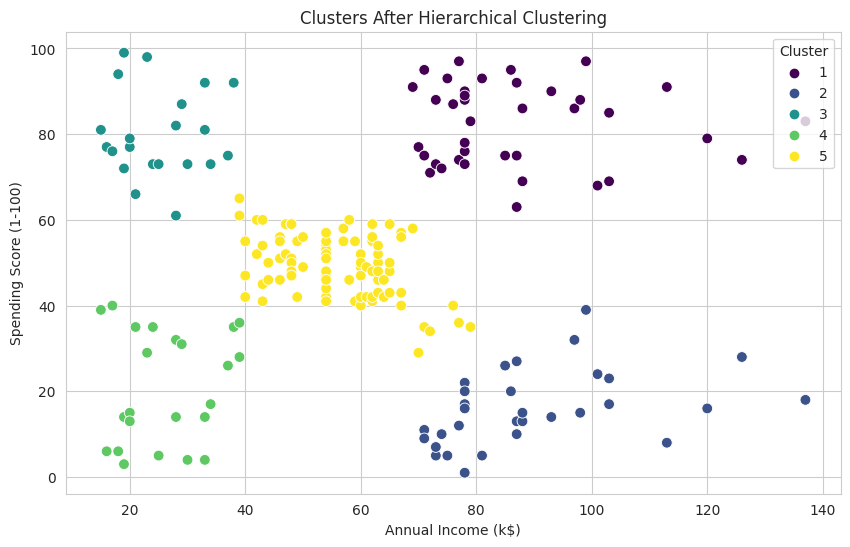

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

data_for_clustering = df[['Annual Income (k$)', 'Spending Score (1-100)']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

linkage_matrix = linkage(scaled_data, method='ward')
num_clusters = 5
clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
df['Cluster'] = clusters
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis', s=60)
plt.title("Clusters After Hierarchical Clustering")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
plt.show()

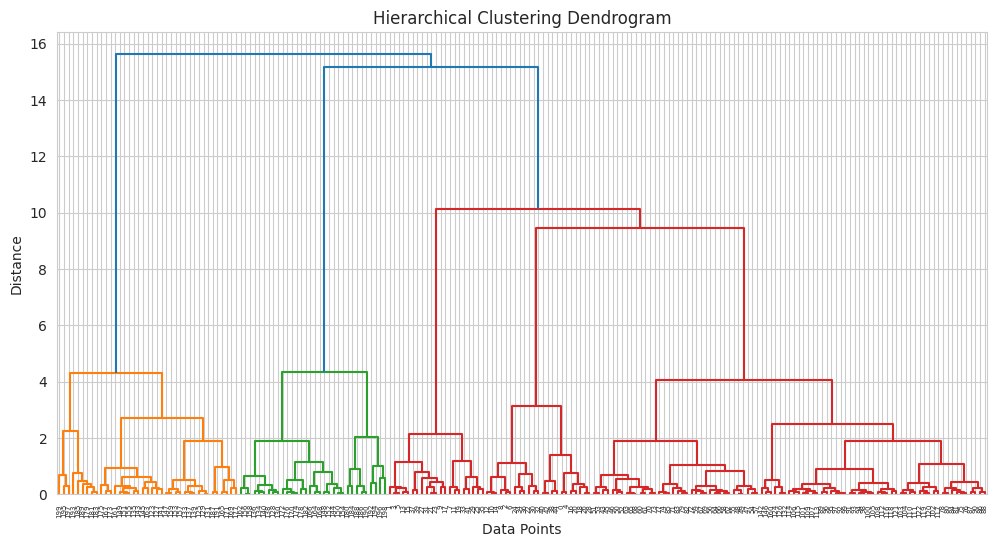

In [ ]:
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

# DBSCAN


No DBSCAN existem dois hiperparâmetros principais:
*   eps
*   min_samples

É difícil dizer arbitrariamente quais valores funcionarão melhor. Portanto, primeiro criarei uma matriz de combinações investigadas.

In [ ]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))


Como o próprio DBSCAN cria clusters com base nesses dois parâmetros, vamos verificar o número de clusters gerados

In [ ]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))


Um gráfico de calor abaixo mostra quantos clusters foram gerados pelo algoritmo DBSCAN para as respectivas combinações de parâmetros.

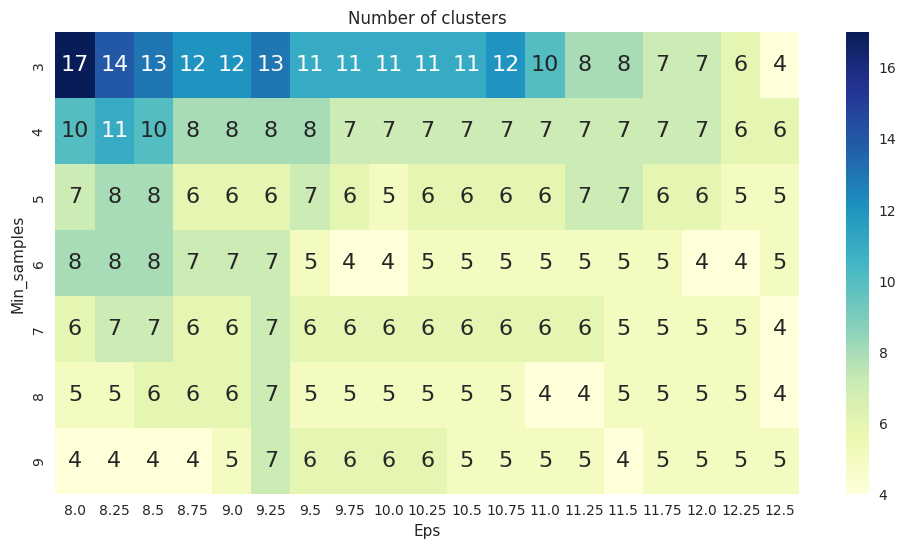

In [ ]:

tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()


O gráfico de calor acima mostra que o número de clusters varia de 17 a 4. No entanto, a maioria das combinações fornece de 4 a 7 clusters. Para decidir qual combinação escolher, usarei uma métrica - uma pontuação de silhueta e a traçarei como um mapa de calor novamente.

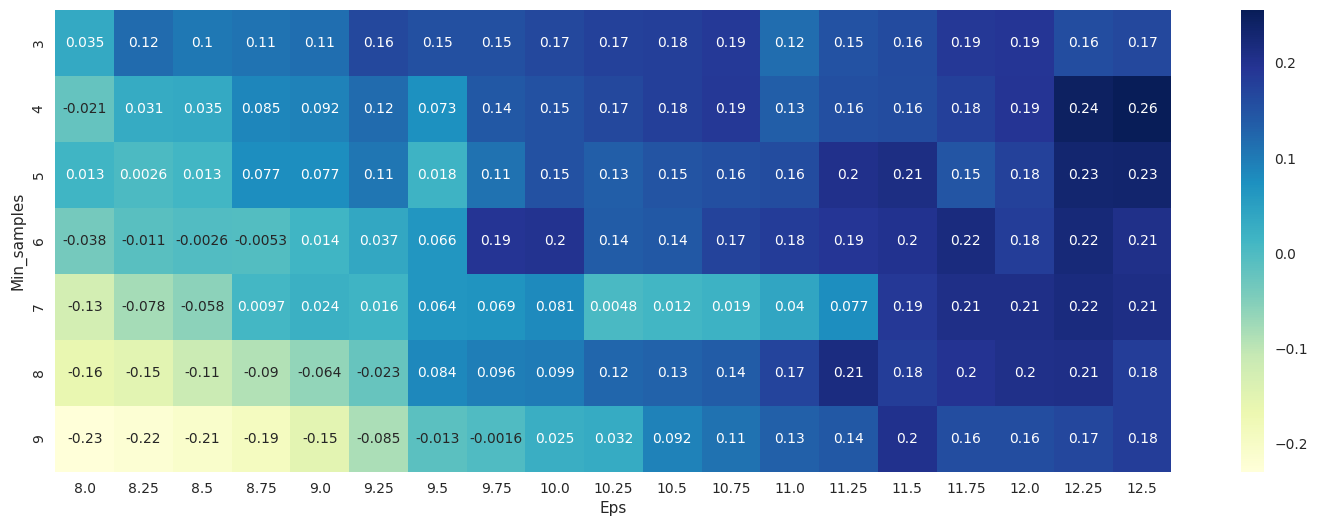

In [ ]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()


O máximo global é 0,26 para eps=12,5 e min_samples=4.

In [ ]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points


Verificando tamanhos de clusters

In [ ]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4



DBSCAN criou 5 clusters mais cluster de outliers (-1). Os tamanhos dos clusters 0-4 variam significativamente - alguns têm apenas 4 ou 8 observações. Existem 18 valores discrepantes.

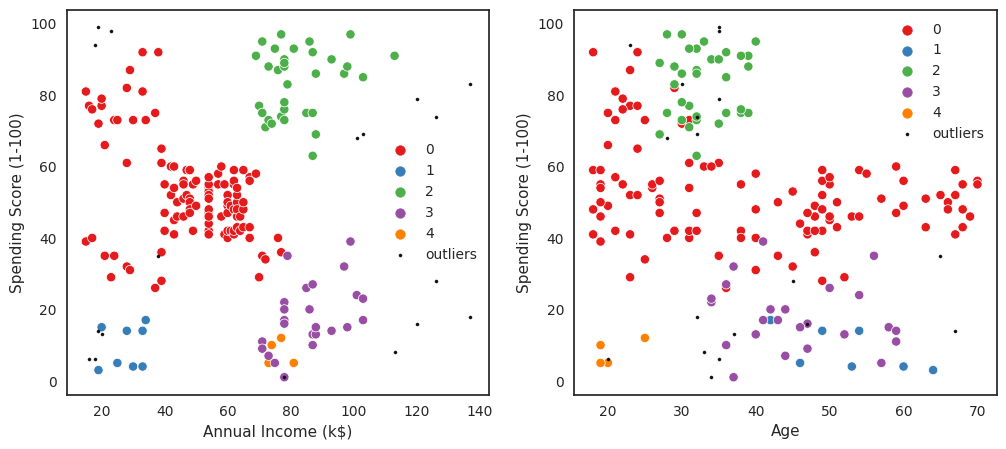

In [ ]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', s=45)

sns.scatterplot(x='Age', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()



O gráfico acima mostra que existem alguns outliers - esses pontos não atendem aos requisitos de distância e amostras mínimas para serem reconhecidos como um cluster.

# Agglomerative clustering

In [43]:
# Carregando dataset
df = pd.read_csv('/content/drive/MyDrive/tarefa clustering Joao/segmentation_data.csv')

In [45]:
data_model = df.drop(['CustomerID'], axis=1)
data_model['Gender'] = data_model['Gender'].factorize()[0]
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [24]:
from sklearn.cluster import AgglomerativeClustering as AggClus

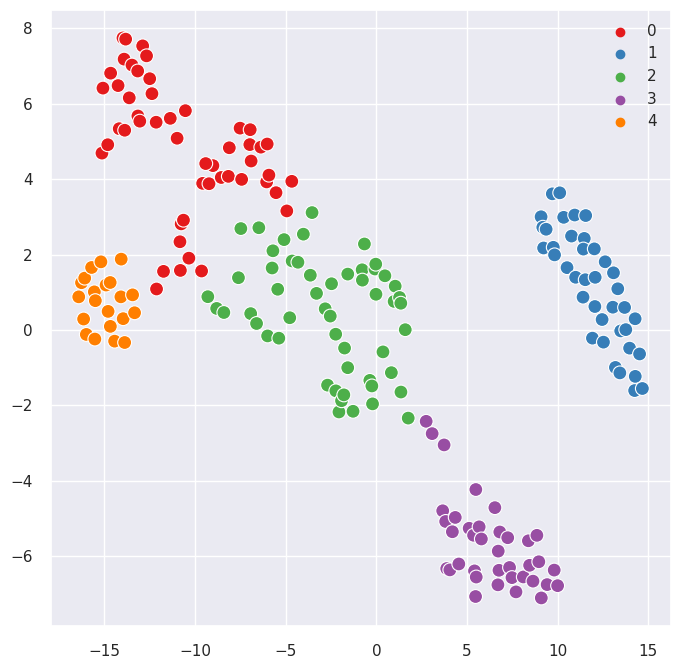

In [35]:
# Codifique a coluna "Gender" em variáveis dummy
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

# Reduza a dimensionalidade usando t-SNE
tsne = TSNE(n_components=2, random_state=42)
res_tsne = tsne.fit_transform(df)

# Crie um objeto AgglomerativeClustering
clus_mod = AgglomerativeClustering(n_clusters=5)

# Ajuste e preveja os clusters
assign = clus_mod.fit_predict(df)

# Visualize os clusters com base nos resultados do t-SNE
plt.figure(figsize=(8, 8))
sns.set(style='darkgrid', palette='muted')
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=res_tsne[:, 0], y=res_tsne[:, 1], s=100, hue=assign, palette='Set1')

# Exiba o gráfico
plt.show()



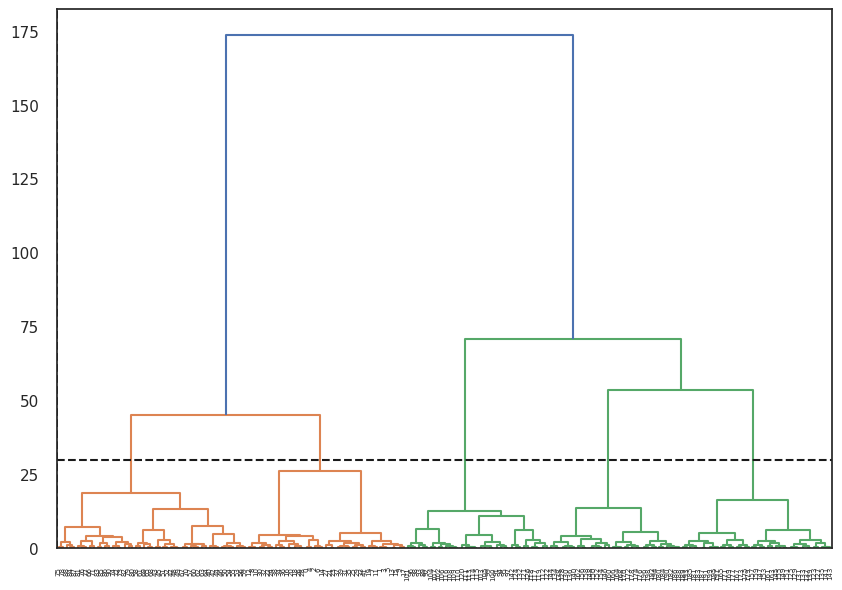

In [46]:
from scipy.cluster.hierarchy import dendrogram, ward
sns.set(style='white')
plt.figure(figsize=(10,7))
link = ward(res_tsne)
dendrogram(link)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [30,30],'--', c='k')
ax.plot(bounds,'--', c='k')
plt.show()

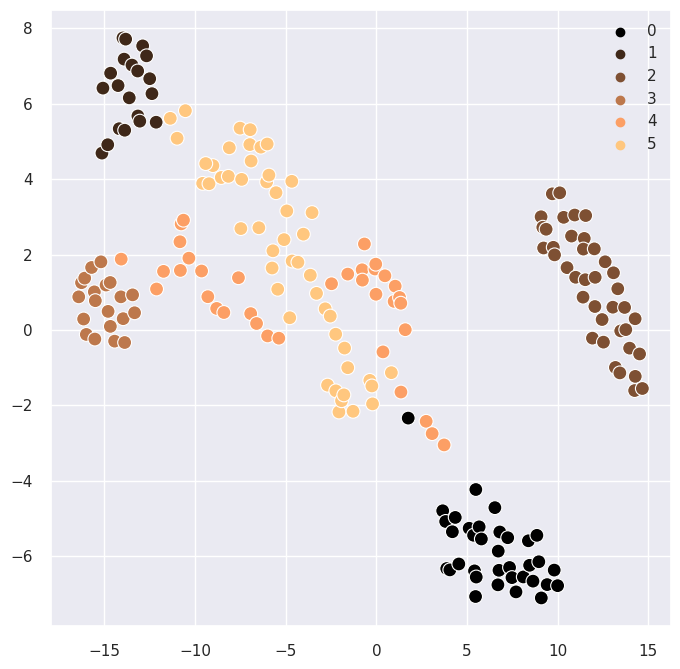

In [49]:
clus_mod = AggClus(n_clusters=6)
assign = clus_mod.fit_predict(data_model)
plt.figure(figsize=(8,8))
sns.set(style='darkgrid',palette='muted')
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=res_tsne[:,0],y=res_tsne[:,1],s=100, hue=assign, palette='copper');

In [56]:
data_model.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),predict
0,0,19,15,39,1
1,0,21,15,81,3
2,1,20,16,6,1
3,1,23,16,77,3
4,1,31,17,40,1


In [57]:
data_model['predict'] = pd.DataFrame(assign)

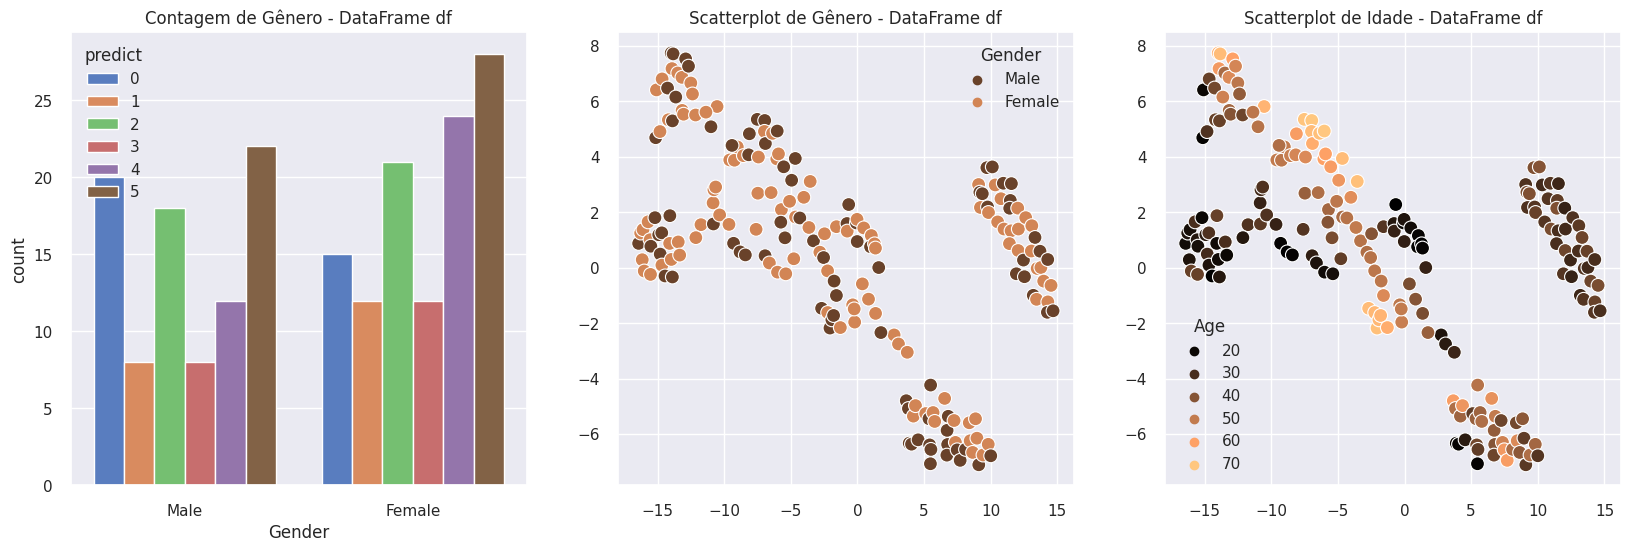

In [60]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(3, 3, 1)
sns.countplot(x='Gender', data=df, hue=data_model['predict'], ax=ax1)
ax2 = fig.add_subplot(3, 3, 2)
sns.scatterplot(x=res_tsne[:, 0], y=res_tsne[:, 1], s=100, hue=df['Gender'], palette='copper', ax=ax2)
ax3 = fig.add_subplot(3, 3, 3)
sns.scatterplot(x=res_tsne[:, 0], y=res_tsne[:, 1], s=100, hue=df['Age'], palette='copper', ax=ax3)

# Adicione títulos aos subplots, se desejar
ax1.set_title('Contagem de Gênero - DataFrame df')
ax2.set_title('Scatterplot de Gênero - DataFrame df')
ax3.set_title('Scatterplot de Idade - DataFrame df')

# Exiba o gráfico
plt.show()


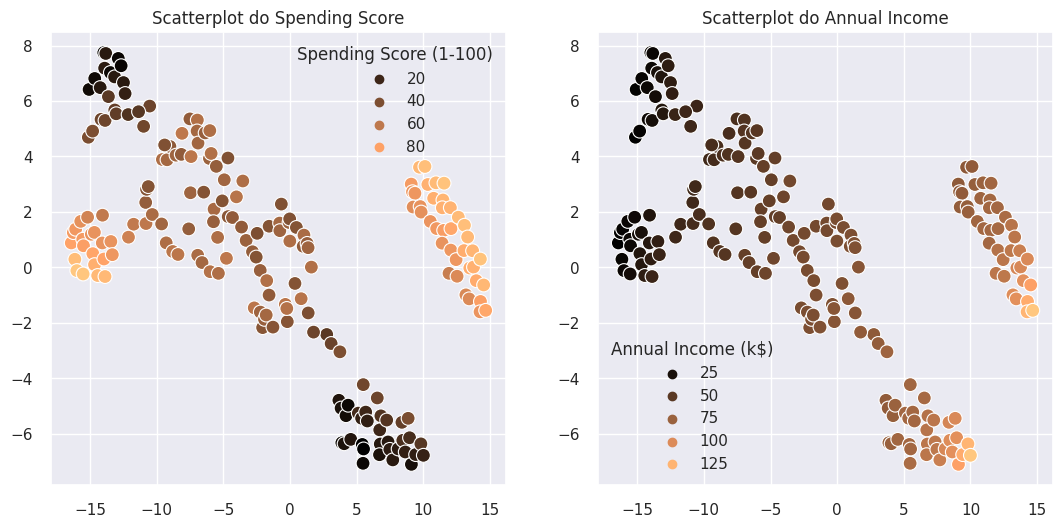

In [63]:
fig = plt.figure(figsize=(20, 20))

# Gráfico de dispersão com base na coluna 'Spending Score (1-100)'
ax1 = fig.add_subplot(3, 3, 1)
sns.scatterplot(x=res_tsne[:, 0], y=res_tsne[:, 1], s=100, hue=df['Spending Score (1-100)'], palette='copper', ax=ax1)

# Gráfico de dispersão com base na coluna 'Annual Income (k$)'
ax2 = fig.add_subplot(3, 3, 2)
sns.scatterplot(x=res_tsne[:, 0], y=res_tsne[:, 1], s=100, hue=df['Annual Income (k$)'], palette='copper', ax=ax2)

# Adicione títulos aos subplots, se desejar
ax1.set_title('Scatterplot do Spending Score')
ax2.set_title('Scatterplot do Annual Income')

# Exiba o gráfico
plt.show()



Aqui podemos ver que, exceto o gênero, outras características dão resultados significativos.

In [64]:
model = pd.DataFrame()
model['age'] = data_model['Age'].groupby(data_model['predict']).median()
model['annual income'] = data_model['Annual Income (k$)'].groupby(data_model['predict']).median()
model['spending score'] = data_model['Spending Score (1-100)'].groupby(data_model['predict']).median()
model.reset_index(inplace=True)


Nesta tarefa temos raras chances de uma visualização bidimensional dos dados. Usamos isso para construir gráficos de silhueta. Este gráfico mostra a qualidade do cluster.


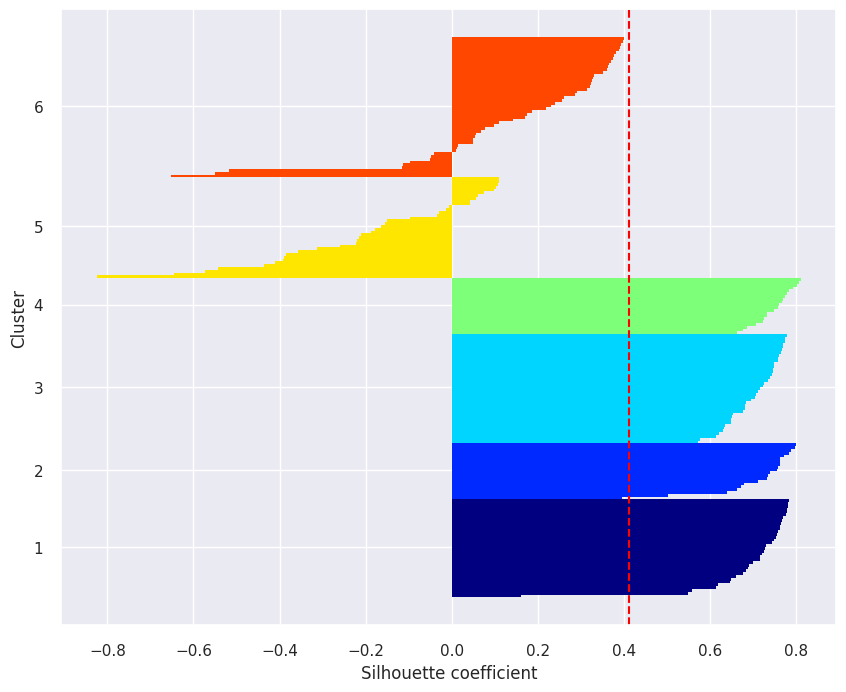

In [66]:
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(assign)
n_clusters = len(np.unique(assign))
silhouette_vals = silhouette_samples(res_tsne, assign, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []

plt.figure(figsize=(10, 8))

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[assign == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)

plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.show()


Este cronograma de cluster não parece perfeito. Mas podemos compará-lo com outras variantes:

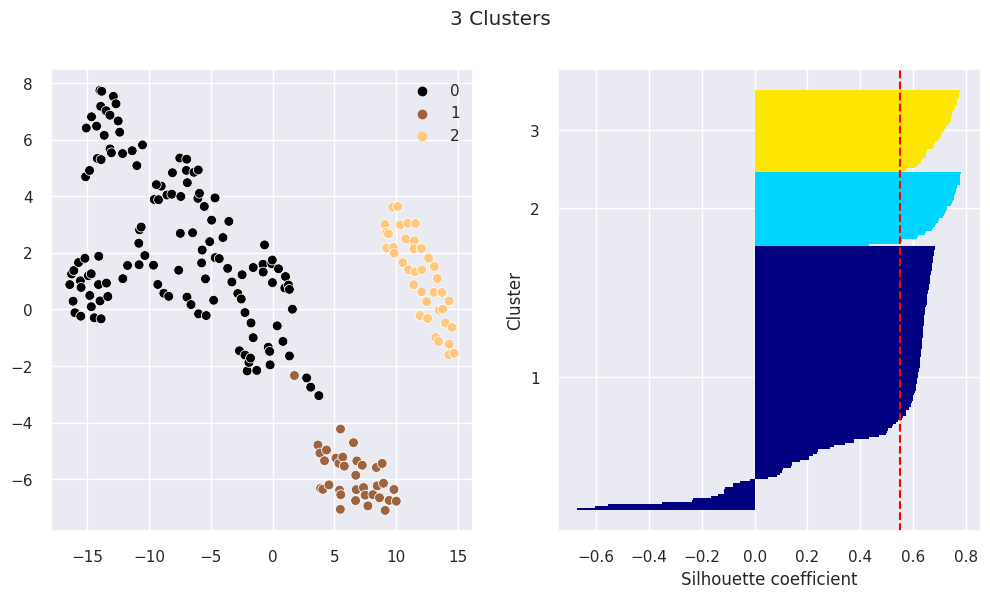

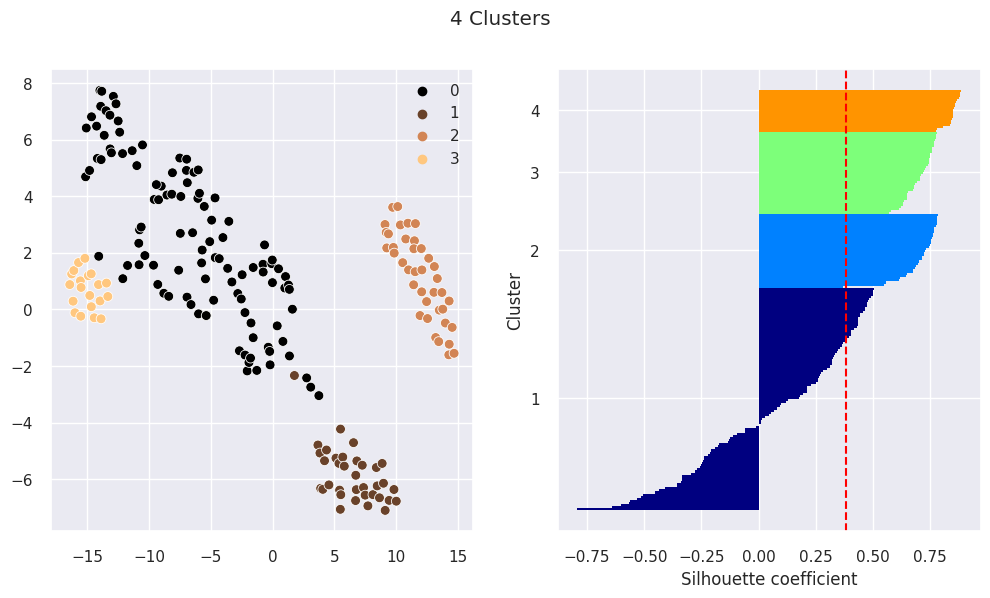

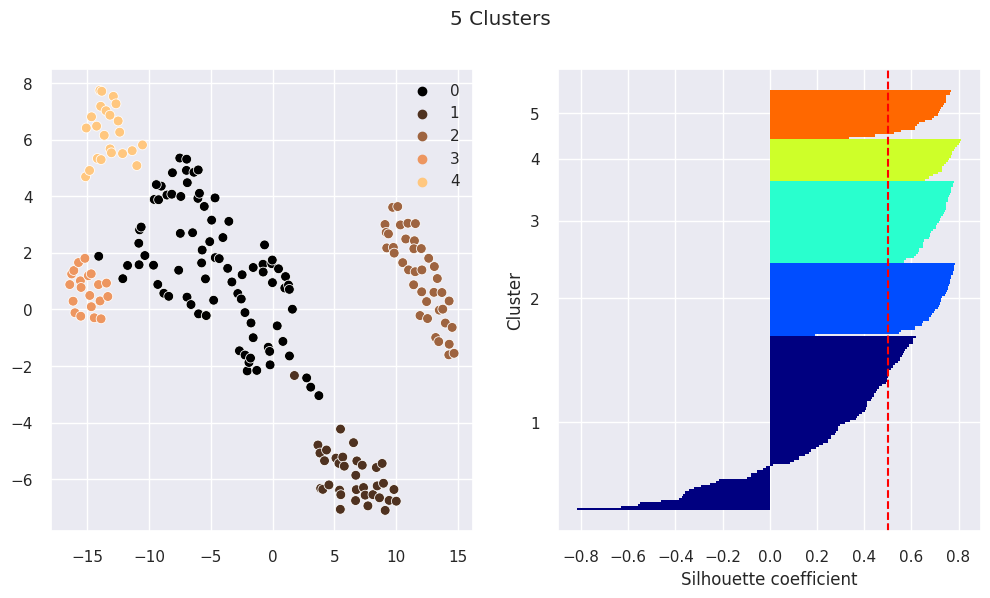

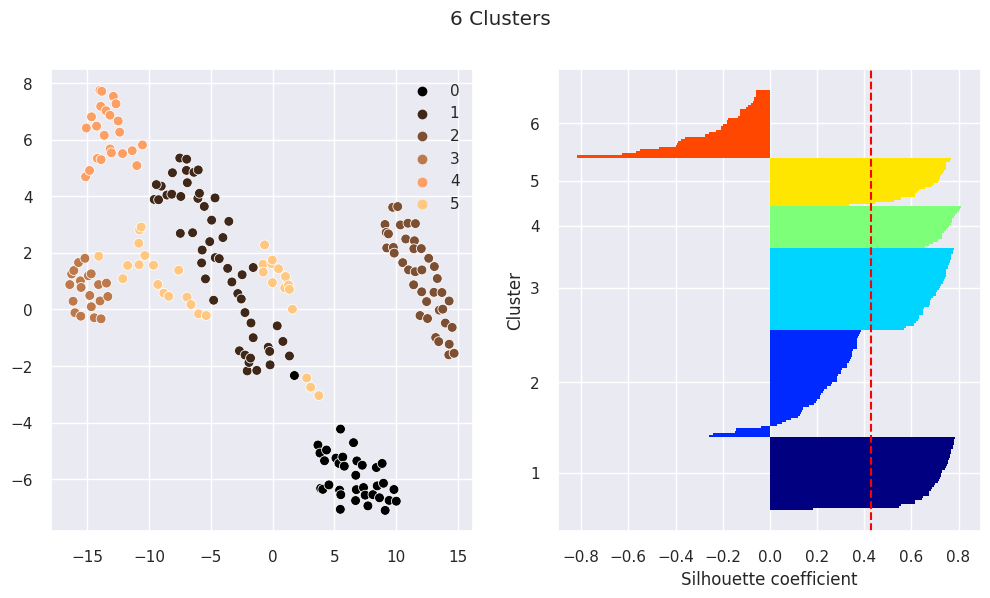

In [69]:
def clust_sill(num):
    fig = plt.figure(figsize=(12, 6))

    clus_mod = AggClus(n_clusters=num)
    assign = clus_mod.fit_predict(data_model)
    sns.set(style='darkgrid', palette='muted')
    cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

    ax1 = fig.add_subplot(1, 2, 1)
    sns.scatterplot(x=res_tsne[:, 0], y=res_tsne[:, 1], s=50, hue=assign, palette='copper', ax=ax1)

    cluster_labels = np.unique(assign)
    n_clusters = len(np.unique(assign))
    silhouette_vals = silhouette_samples(res_tsne, assign, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    ax2 = fig.add_subplot(1, 2, 2)
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[assign == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        ax2.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)

    ax2.axvline(silhouette_avg, color="red", linestyle="--")
    ax2.set_yticks(yticks, cluster_labels + 1)
    ax2.set_ylabel('Cluster')
    ax2.set_xlabel('Silhouette coefficient')

    plt.suptitle(str(num) + ' Clusters')
    plt.show()

clust_sill(3)
clust_sill(4)
clust_sill(5)
clust_sill(6)


Aparentemente 5 cluster seriam o ideal

In [71]:
# Exemplo para calcular as médias das características para cada cluster em K-Means
cluster_means = df.groupby('Cluster')['Age', 'Annual Income (k$)', 'Spending Score (1-100)'].mean()
print(cluster_means)


KeyError: ignored

# Respostas

In [82]:
import plotly.graph_objects as go
from sklearn.cluster import KMeans
import pandas as pd

# Defina uma semente aleatória para reprodutibilidade
random_seed = 42

# Aplicar o algoritmo K-Means para clusterização
km = KMeans(n_clusters=5, random_state=random_seed)
clusters = km.fit_predict(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

# Adicionar coluna 'Cluster' ao DataFrame
df['Cluster'] = clusters

# Número de perfis de clientes segmentados
num_profiles = len(df['Cluster'].unique())

# Principais características dos clientes segmentados
cluster_means = df.groupby('Cluster').mean()

# Identificação do Cluster mais dominante e menos dominante
cluster_sizes = df['Cluster'].value_counts()
dominant_cluster = cluster_sizes.idxmax()
minority_cluster = cluster_sizes.idxmin()

# Pontuação de silhueta para avaliar a diferenciação dos clusters
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], df['Cluster'])

# Imprimir as respostas
print("Número de perfis de clientes segmentados:", num_profiles)
print("Principais características dos clientes segmentados:")
print(cluster_means)
print("Cluster mais dominante:", dominant_cluster)
print("Cluster menos dominante:", minority_cluster)

# Avaliar se os clusters estão bem separados com base na pontuação de silhueta
if silhouette_avg > 0.5:
    print("Os clusters estão bem separados.")
elif 0.2 <= silhouette_avg <= 0.5:
    print("Os clusters têm uma separação razoável.")
else:
    print("Os clusters podem não estar bem separados.")



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-82-2de0ab6744e0>:19: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Número de perfis de clientes segmentados: 5
Principais características dos clientes segmentados:
         CustomerID        Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                                   
0         23.000000  45.217391           26.304348               20.913043
1        162.000000  32.692308           86.538462               82.128205
2        162.945946  40.324324           87.432432               18.189189
3         85.012658  43.126582           54.822785               49.835443
4         23.090909  25.272727           25.727273               79.363636
Cluster mais dominante: 3
Cluster menos dominante: 4
Os clusters têm uma separação razoável.
